# Read Data and Split

In [18]:
# Load all helper function
%run -i 'source.py'

dataset = pd.read_feather("../processing/train_with_feature.feather")
te_features = []
ohe_features = []

X = dataset[numc_features + ohe_features + te_features]
y = dataset['is_attributed']

**Since the dataset is too big, we use only 500,000 rows to train and test our model.**

**We have 62,360,949 rows in our entire data. While building these models let's only have 500,000 rows. (That is .81% of the original data.)**

In [19]:
X, _,y,_ = train_test_split(X,y,random_state=4995,train_size=.0081,stratify=y)

print(len(X))

505123


In [20]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=4995, test_size=0.2, stratify=y)

In [4]:
print(f'Proportion of data in development set: {len(X_dev)/len(X):0.2f}')
print('Confirm we have a stratified split. 0 represents negative (no download); 1 represents positive (yes download)')
print(f'Proportion of positives in entire data set: {np.mean(y):0.5f}')
print(f'Proportion of positives in development set: {np.mean(y_dev):0.5f}')
print(f'Proportion of positives in test set: {np.mean(y_test):0.5f}')

Proportion of data in development set: 0.80
Confirm we have a stratified split. 0 represents negative (no download); 1 represents positive (yes download)
Proportion of positives in entire data set: 0.00243
Proportion of positives in development set: 0.00243
Proportion of positives in test set: 0.00243


# SMOTE Development Dataset

In [5]:
print(f'Original development data distribution of labels: {Counter(y_dev)}')

Original development data distribution of labels: Counter({0: 403117, 1: 981})


In [6]:
print('We use SMOTE to balance our dataset.')
smote = SMOTE()
X_dev_SMOTE, y_dev_SMOTE = smote.fit_resample(X_dev, y_dev) # It is okay to do smote first since for now we are not doing any hyperparameter tuning.
print(f'After SMOTE our development data has the shape: {Counter(y_dev_SMOTE)}')

We use SMOTE to balance our dataset.
After SMOTE our development data has the shape: Counter({0: 403117, 1: 403117})


# Preprocessing

We need to scale our data since SVMs rely on distance between points.

In [7]:
scaler = MinMaxScaler()
X_dev_SMOTE_scaled = scaler.fit_transform(X_dev_SMOTE) #No pipeline needed for now since we aren't doing cv

# Build Model (no tuning)

In [8]:
svm = LinearSVC() #should scale better to large numbers of samples.
svm.fit(X_dev_SMOTE_scaled, y_dev_SMOTE)

LinearSVC()

In [9]:
X_test_scaled = scaler.transform(X_test)
svm_predictions = svm.predict(X_test_scaled)

print(f'Accuracy: {accuracy_score(y_test,svm_predictions)}')
print(f'Recall: {recall_score(y_test,svm_predictions)}')
print(f'Precision: {precision_score(y_test,svm_predictions)}')
print(f'F-1 Score: {f1_score(y_test,svm_predictions)}')

recall, precision = recall_score(y_test,svm_predictions), precision_score(y_test,svm_predictions)

Accuracy: 0.9950507300173225
Recall: 0.926530612244898
Precision: 0.32016925246826516
F-1 Score: 0.4758909853249476


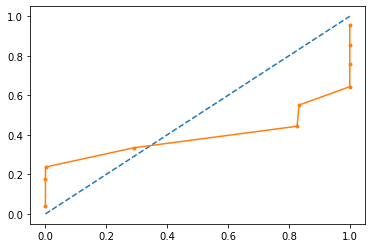

In [10]:
probs = svm.decision_function(X_test_scaled)
a, b = calibration_curve(y_test, probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(a, b, marker='.')

# Let's try calibrating the model

In [11]:
from imblearn.pipeline import Pipeline    
svm = Pipeline([('scaler',MinMaxScaler()),('smote',SMOTE()),('classifier',LinearSVC())])

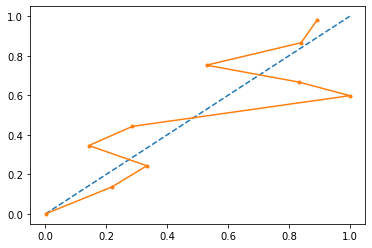

In [12]:
from sklearn.calibration import CalibratedClassifierCV
calibratedSVM = CalibratedClassifierCV(svm, method='sigmoid',cv=5)
calibratedSVM.fit(X_dev, y_dev)

probs = calibratedSVM.predict_proba(X_test)[:, 1]
a, b = calibration_curve(y_test, probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(a, b, marker='.')

In [13]:
pred = calibratedSVM.predict(X_test)
prob = calibratedSVM.predict_proba(X_test)


print(f'Accuracy: {accuracy_score(y_test,pred)}')
print(f'Recall: {recall_score(y_test,pred)}')
print(f'Precision: {precision_score(y_test,pred)}')
print(f'F-1 Score: {f1_score(y_test,pred)}')

recall, precision = recall_score(y_test,pred), precision_score(y_test,pred)

Accuracy: 0.9988220737441228
Recall: 0.6244897959183674
Precision: 0.85
F-1 Score: 0.7200000000000001


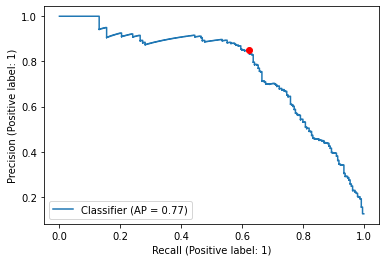

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_test, prob[:, 1])
plt.plot(recall,precision,'ro');

# Tune Hyperparameters: Overall, much better than logistic regression. Change Threshold to prioritize recall.

**SMOTE must be part of the imblearn.pipeline so it isn't applied to the validation folds.**

In [15]:
svm_2 = Pipeline([('scaler',MinMaxScaler()),('smote',SMOTE()),('classifier',LinearSVC())])
parameter_grid = {'classifier__C':np.logspace(-2, 1, 10)}

gridsearch = GridSearchCV(svm_2, parameter_grid, cv=5, n_jobs=-1, scoring=['recall','f1'],refit='f1')
Calibrated_svm_2 = CalibratedClassifierCV(gridsearch)
Calibrated_svm_2.fit(X_dev,y_dev)

CalibratedClassifierCV(base_estimator=GridSearchCV(cv=5,
                                                   estimator=Pipeline(steps=[('scaler',
                                                                              MinMaxScaler()),
                                                                             ('smote',
                                                                              SMOTE()),
                                                                             ('classifier',
                                                                              LinearSVC())]),
                                                   n_jobs=-1,
                                                   param_grid={'classifier__C': array([ 0.01      ,  0.02154435,  0.04641589,  0.1       ,  0.21544347,
        0.46415888,  1.        ,  2.15443469,  4.64158883, 10.        ])},
                                                   refit='f1',
                                               

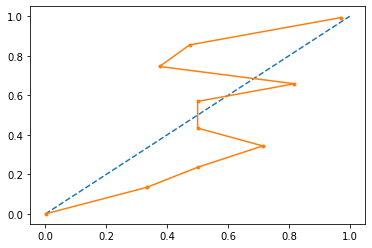

In [16]:
probs = Calibrated_svm_2.predict_proba(X_test)[:, 1]
a, b = calibration_curve(y_test, probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(a, b, marker='.')

In [17]:
pred = Calibrated_svm_2.predict(X_test)
prob = Calibrated_svm_2.predict_proba(X_test)


print(f'Accuracy: {accuracy_score(y_test,pred)}')
print(f'Recall: {recall_score(y_test,pred)}')
print(f'Precision: {precision_score(y_test,pred)}')
print(f'F-1 Score: {f1_score(y_test,pred)}')

recall, precision = recall_score(y_test,pred), precision_score(y_test,pred)

Accuracy: 0.9989111606038109
Recall: 0.6653061224489796
Precision: 0.8534031413612565
F-1 Score: 0.7477064220183486


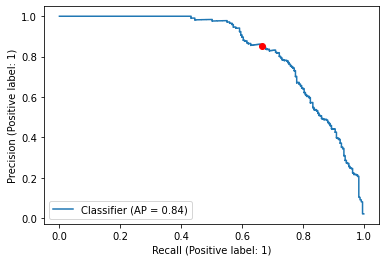

In [18]:
PrecisionRecallDisplay.from_predictions(y_test, prob[:, 1])
plt.plot(recall,precision,'ro');

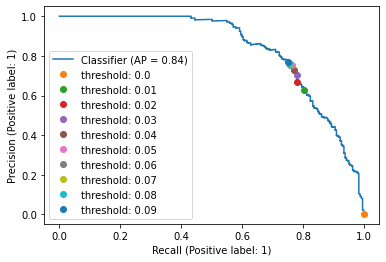

In [19]:
PrecisionRecallDisplay.from_predictions(y_test, prob[:, 1])

thresholds = list(np.arange(0,.1,.01))
for threshold in thresholds:
    pred = (Calibrated_svm_2.predict_proba(X_test)[:,1]>=threshold).astype(bool)
    recall, precision = recall_score(y_test,pred), precision_score(y_test,pred)
    plt.plot(recall,precision,'o',label=f'threshold: {threshold}');
    plt.legend()



We see if we set the threshold to be extremely low, (.01), we get the following results.

In [20]:
pred = (Calibrated_svm_2.predict_proba(X_test)[:,1]>=.01).astype(bool)

print(f'Accuracy: {accuracy_score(y_test,pred)}')
print(f'Recall: {recall_score(y_test,pred)}')
print(f'Precision: {precision_score(y_test,pred)}')
print(f'F-1 Score: {f1_score(y_test,pred)}')

recall, precision = recall_score(y_test,pred), precision_score(y_test,pred)

Accuracy: 0.9983766394456818
Recall: 0.8040816326530612
Precision: 0.6293929712460063
F-1 Score: 0.7060931899641577


In [21]:
import pickle
filename = '../processing/LinearSVM.sav'
pickle.dump(Calibrated_svm_2, open(filename, 'wb'))

In [2]:
# to load model...
import pickle
filename = '../processing/LinearSVM.sav'
SVM_loaded = pickle.load(open(filename, 'rb'))